In [21]:
from transformers import pipeline, AutoModelForQuestionAnswering, AutoTokenizer, AutoModel
from openai import OpenAI
import pandas as pd
import os
import logging
import time
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from io import StringIO

### Создание датасета с моделями

In [7]:
models_list = [
    ('deepset/roberta-base-squad2',
     'https://huggingface.co/deepset/roberta-base-squad2', '124'),
    ('deepset/gelectra-base-germanquad',
     'https://huggingface.co/deepset/gelectra-base-germanquad', '109'),
    ('distilbert/distilbert-base-cased-distilled-squad',
     'https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad', '65'),
    ('timpal0l/mdeberta-v3-base-squad2',
     'https://huggingface.co/timpal0l/mdeberta-v3-base-squad2', '278'),
    ('deepset/bert-large-uncased-whole-word-masking-squad2',
     'https://huggingface.co/deepset/bert-large-uncased-whole-word-masking-squad2', '335'),
    ('monologg/koelectra-small-v2-distilled-korquad-384',
     'https://huggingface.co/monologg/koelectra-small-v2-distilled-korquad-384', '13'),
    ('distilbert/distilbert-base-uncased-distilled-squad',
     'https://huggingface.co/distilbert/distilbert-base-uncased-distilled-squad', '66'),
    ('deepset/tinyroberta-squad2',
     'https://huggingface.co/deepset/tinyroberta-squad2', '81'),
    ('deepset/electra-base-squad2',
     'https://huggingface.co/deepset/electra-base-squad2', '109'),
    ('csarron/mobilebert-uncased-squad-v2',
     'https://huggingface.co/csarron/mobilebert-uncased-squad-v2', '104'),
    ('monologg/koelectra-base-v3-finetuned-korquad',
     'https://huggingface.co/monologg/koelectra-base-v3-finetuned-korquad', '112'),
    ('varun-v-rao/opt-1.3b-squad-model3',
     'https://huggingface.co/varun-v-rao/opt-1.3b-squad-model3', '1300')
]

models_df = pd.DataFrame(models_list,  columns=[
                         'model_name', 'link', 'model_size(M)'])
models_df['model_size(M)'] = models_df['model_size(M)'].astype(int)
models_df = models_df.sort_values(by=['model_size(M)']).reset_index(drop=True)
models_df

,model_name,link,model_size(M)
0,monologg/koelectra-small-v2-distilled-korquad-384,https://huggingface.co/monologg/koelectra-smal...,13
1,distilbert/distilbert-base-cased-distilled-squad,https://huggingface.co/distilbert/distilbert-b...,65
2,distilbert/distilbert-base-uncased-distilled-s...,https://huggingface.co/distilbert/distilbert-b...,66
3,deepset/tinyroberta-squad2,https://huggingface.co/deepset/tinyroberta-squad2,81
4,csarron/mobilebert-uncased-squad-v2,https://huggingface.co/csarron/mobilebert-unca...,104
5,deepset/gelectra-base-germanquad,https://huggingface.co/deepset/gelectra-base-g...,109
6,deepset/electra-base-squad2,https://huggingface.co/deepset/electra-base-sq...,109
7,monologg/koelectra-base-v3-finetuned-korquad,https://huggingface.co/monologg/koelectra-base...,112
8,deepset/roberta-base-squad2,https://huggingface.co/deepset/roberta-base-sq...,124
9,timpal0l/mdeberta-v3-base-squad2,https://huggingface.co/timpal0l/mdeberta-v3-ba...,278


https://huggingface.co/datasets/databricks/databricks-dolly-15k?row=5

### Загрузка и предобработка датасета вопросов

In [1]:
import pandas as pd
from datasets import load_dataset

dataset = load_dataset("databricks/databricks-dolly-15k")
train_dataset = dataset["train"]

data = train_dataset.to_pandas()
data.head()

,instruction,context,response,category
0,When did Virgin Australia start operating?,"Virgin Australia, the trading name of Virgin A...",Virgin Australia commenced services on 31 Augu...,closed_qa
1,Which is a species of fish? Tope or Rope,,Tope,classification
2,Why can camels survive for long without water?,,Camels use the fat in their humps to keep them...,open_qa
3,"Alice's parents have three daughters: Amy, Jes...",,The name of the third daughter is Alice,open_qa
4,When was Tomoaki Komorida born?,Komorida was born in Kumamoto Prefecture on Ju...,"Tomoaki Komorida was born on July 10,1981.",closed_qa


In [2]:
data['context'] = data['context'].replace('', None)
data = data[data['context'].notna()]
data = data[['instruction', 'context']].rename(
    columns={'instruction': 'question'}).reset_index(drop=True)
data.head(15)

,question,context
0,When did Virgin Australia start operating?,"Virgin Australia, the trading name of Virgin A..."
1,When was Tomoaki Komorida born?,Komorida was born in Kumamoto Prefecture on Ju...
2,If I have more pieces at the time of stalemate...,Stalemate is a situation in chess where the pl...
3,"Given a reference text about Lollapalooza, whe...",Lollapalooza /ˌlɒləpəˈluːzə/ (Lolla) is an ann...
4,Who was John Moses Browning?,"John Moses Browning (January 23, 1855 – Novemb..."
5,Who is Thomas Jefferson?,"Thomas Jefferson (April 13, 1743 – July 4, 182..."
6,Who was Kyle Van Zyl playing against when he s...,Van Zyl joined the Eastern Province Kings Acad...
7,From the passage list down the areas for which...,Dar es Salaam (/ˌdɑːr ɛs səˈlɑːm/; from Arabic...
8,What is process mining?,Process mining is a family of techniques relat...
9,What is a dispersive prism?,"In optics, a dispersive prism is an optical pr..."


In [10]:
for i in range(15):
    print(data['question'][i])

When did Virgin Australia start operating?
When was Tomoaki Komorida born?
If I have more pieces at the time of stalemate, have I won?
Given a reference text about Lollapalooza, where does it take place, who started it and what is it?
Who was John Moses Browning?
Who is Thomas Jefferson?
Who was Kyle Van Zyl playing against when he scored 36 of hisa teams 61 points?
From the passage list down the areas for which Dar es Salaam is Tanzania's most prominent city. List the results in comma separated format.
What is process mining?
What is a dispersive prism?
Extract the owner of Lamborghini and a listing of the different types of Huracan cars that Lamborghini has produced for its Motorsport division.
What is the average lifespan of a Golden Retriever?
Please summarize what Linkedin does.
Using examples taken from the text give me a summary of the main arguments in favour of slavery reparations in the United States and the anticipated cost of enacting such reparations
Who was the first to r

### Получение ответов на вопросы

In [5]:
def get_answer(model_name, question, context):
    qa_pipeline = pipeline("question-answering",
                           model=model_name, tokenizer=model_name)

    answer = qa_pipeline({
        'context': context,
        'question': question
    })['answer']

    return answer

In [6]:
models_df

,model_name,link,model_size(M)
0,monologg/koelectra-small-v2-distilled-korquad-384,https://huggingface.co/monologg/koelectra-smal...,13
1,distilbert/distilbert-base-cased-distilled-squad,https://huggingface.co/distilbert/distilbert-b...,65
2,distilbert/distilbert-base-uncased-distilled-s...,https://huggingface.co/distilbert/distilbert-b...,66
3,deepset/tinyroberta-squad2,https://huggingface.co/deepset/tinyroberta-squad2,81
4,csarron/mobilebert-uncased-squad-v2,https://huggingface.co/csarron/mobilebert-unca...,104
5,deepset/gelectra-base-germanquad,https://huggingface.co/deepset/gelectra-base-g...,109
6,deepset/electra-base-squad2,https://huggingface.co/deepset/electra-base-sq...,109
7,monologg/koelectra-base-v3-finetuned-korquad,https://huggingface.co/monologg/koelectra-base...,112
8,deepset/roberta-base-squad2,https://huggingface.co/deepset/roberta-base-sq...,124
9,timpal0l/mdeberta-v3-base-squad2,https://huggingface.co/timpal0l/mdeberta-v3-ba...,278


In [18]:
logging.getLogger("transformers").setLevel(logging.ERROR)

answers = []
for _, row_data in tqdm(data.iloc[:15, :].iterrows()):
    question = row_data['question']
    context = row_data['context']

    for _, row_models in models_df.iterrows():
        model_name = row_models['model_name']
        answer = get_answer(model_name, question, context)
        answers.append(answer)

0it [00:00, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

1it [00:18, 18.99s/it]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2it [00:38, 19.18s/it]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

3it [00:55, 18.44s/it]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

4it [01:13, 18.22s/it]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

5it [01:36, 19.89s/it]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

6it [01:55, 19.45s/it]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

7it [02:15, 19.82s/it]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

8it [02:38, 20.87s/it]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

9it [03:08, 23.51s/it]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

10it [03:31, 23.38s/it]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

11it [04:14, 29.47s/it]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

12it [04:33, 26.14s/it]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

13it [04:53, 24.47s/it]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

14it [05:25, 26.59s/it]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

15it [05:46, 23.07s/it]


In [23]:
pd.Series(answers)

0                    Ltd
1         31 August 2000
2         31 August 2000
3         31 August 2000
4         31 August 2000
             ...        
175            DeShannon
176     Jackie DeShannon
177     Jackie DeShannon
178     Jackie DeShannon
179     Jackie DeShannon
Length: 180, dtype: object

In [24]:
pd.Series(answers).to_csv('data/answers.csv', index=True)

### Создание единого датафрейма

In [13]:
context = data['context'].iloc[:15]
context_df = pd.DataFrame(context)
context_df = context_df.loc[context_df.index.repeat(12)].reset_index(drop=True)
context_df

,context
0,"Virgin Australia, the trading name of Virgin A..."
1,"Virgin Australia, the trading name of Virgin A..."
2,"Virgin Australia, the trading name of Virgin A..."
3,"Virgin Australia, the trading name of Virgin A..."
4,"Virgin Australia, the trading name of Virgin A..."
...,...
175,"""Needles and Pins"" is a rock song credited to ..."
176,"""Needles and Pins"" is a rock song credited to ..."
177,"""Needles and Pins"" is a rock song credited to ..."
178,"""Needles and Pins"" is a rock song credited to ..."


In [14]:
question = data['question'].iloc[:15]
question_df = pd.DataFrame(question)
question_df = question_df.loc[question_df.index.repeat(
    12)].reset_index(drop=True)
question_df

,question
0,When did Virgin Australia start operating?
1,When did Virgin Australia start operating?
2,When did Virgin Australia start operating?
3,When did Virgin Australia start operating?
4,When did Virgin Australia start operating?
...,...
175,Who was the first to record the Needles and Pi...
176,Who was the first to record the Needles and Pi...
177,Who was the first to record the Needles and Pi...
178,Who was the first to record the Needles and Pi...


In [15]:
models_df_name = pd.DataFrame(np.tile(models_df['model_name'], 15))
models_df_name

,0
0,monologg/koelectra-small-v2-distilled-korquad-384
1,distilbert/distilbert-base-cased-distilled-squad
2,distilbert/distilbert-base-uncased-distilled-s...
3,deepset/tinyroberta-squad2
4,csarron/mobilebert-uncased-squad-v2
...,...
175,monologg/koelectra-base-v3-finetuned-korquad
176,deepset/roberta-base-squad2
177,timpal0l/mdeberta-v3-base-squad2
178,deepset/bert-large-uncased-whole-word-masking-...


In [16]:
final_df = pd.concat(
    [models_df_name, question_df, answers, context_df], axis=1)
final_df.columns = ['model_name', 'question', 'answer', 'context']
final_df

,model_name,question,answer,context
0,monologg/koelectra-small-v2-distilled-korquad-384,When did Virgin Australia start operating?,Ltd,"Virgin Australia, the trading name of Virgin A..."
1,distilbert/distilbert-base-cased-distilled-squad,When did Virgin Australia start operating?,31 August 2000,"Virgin Australia, the trading name of Virgin A..."
2,distilbert/distilbert-base-uncased-distilled-s...,When did Virgin Australia start operating?,31 August 2000,"Virgin Australia, the trading name of Virgin A..."
3,deepset/tinyroberta-squad2,When did Virgin Australia start operating?,31 August 2000,"Virgin Australia, the trading name of Virgin A..."
4,csarron/mobilebert-uncased-squad-v2,When did Virgin Australia start operating?,31 August 2000,"Virgin Australia, the trading name of Virgin A..."
...,...,...,...,...
175,monologg/koelectra-base-v3-finetuned-korquad,Who was the first to record the Needles and Pi...,DeShannon,"""Needles and Pins"" is a rock song credited to ..."
176,deepset/roberta-base-squad2,Who was the first to record the Needles and Pi...,Jackie DeShannon,"""Needles and Pins"" is a rock song credited to ..."
177,timpal0l/mdeberta-v3-base-squad2,Who was the first to record the Needles and Pi...,Jackie DeShannon,"""Needles and Pins"" is a rock song credited to ..."
178,deepset/bert-large-uncased-whole-word-masking-...,Who was the first to record the Needles and Pi...,Jackie DeShannon,"""Needles and Pins"" is a rock song credited to ..."


### Создание промтов

In [17]:
def generate_prompts(answers, contexts, questions):
    prompts = []
    for answer, context, question in zip(answers, contexts, questions):
        prompt = f"""
        =Context=
        {context}

        =Question=
        {question}

        =Attempted Answer=
        {answer}

        =Score=
        Please ensure the score is a number from 0 to 10.

        =Explanation=
        Detail the reasoning behind your score, focusing on how well the answer addresses the question within the given context.
        """
        prompts.append(prompt)
    return prompts

In [18]:
final_df['prompt'] = generate_prompts(
    final_df['answer'], final_df['context'], final_df['question'])
final_df

,model_name,question,answer,context,prompt
0,monologg/koelectra-small-v2-distilled-korquad-384,When did Virgin Australia start operating?,Ltd,"Virgin Australia, the trading name of Virgin A...","\n =Context=\n Virgin Australia,..."
1,distilbert/distilbert-base-cased-distilled-squad,When did Virgin Australia start operating?,31 August 2000,"Virgin Australia, the trading name of Virgin A...","\n =Context=\n Virgin Australia,..."
2,distilbert/distilbert-base-uncased-distilled-s...,When did Virgin Australia start operating?,31 August 2000,"Virgin Australia, the trading name of Virgin A...","\n =Context=\n Virgin Australia,..."
3,deepset/tinyroberta-squad2,When did Virgin Australia start operating?,31 August 2000,"Virgin Australia, the trading name of Virgin A...","\n =Context=\n Virgin Australia,..."
4,csarron/mobilebert-uncased-squad-v2,When did Virgin Australia start operating?,31 August 2000,"Virgin Australia, the trading name of Virgin A...","\n =Context=\n Virgin Australia,..."
...,...,...,...,...,...
175,monologg/koelectra-base-v3-finetuned-korquad,Who was the first to record the Needles and Pi...,DeShannon,"""Needles and Pins"" is a rock song credited to ...","\n =Context=\n ""Needles and Pins..."
176,deepset/roberta-base-squad2,Who was the first to record the Needles and Pi...,Jackie DeShannon,"""Needles and Pins"" is a rock song credited to ...","\n =Context=\n ""Needles and Pins..."
177,timpal0l/mdeberta-v3-base-squad2,Who was the first to record the Needles and Pi...,Jackie DeShannon,"""Needles and Pins"" is a rock song credited to ...","\n =Context=\n ""Needles and Pins..."
178,deepset/bert-large-uncased-whole-word-masking-...,Who was the first to record the Needles and Pi...,Jackie DeShannon,"""Needles and Pins"" is a rock song credited to ...","\n =Context=\n ""Needles and Pins..."


In [19]:
final_df.to_csv('data/final_df.csv', index=True)

### Получение оценки с помощью GPT 3.5 - оценщика

In [ ]:
client = OpenAI(
    api_key=api_openai_key,
)


def evaluate_answer(prompt):
    completion = client.completions.create(
        model="gpt-3.5-turbo",
        prompt=prompt,
        max_tokens=300,
        temperature=0.7,
    )
    score_and_evaluate = completion.choices[0].text.strip()
    return score_and_evaluate

In [21]:
evaluate = []
for _, row in final_df.iterrows():
    prompt = row['prompt']
    evaluate.append(evaluate_answer(prompt))


        =Context=
        Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.

        =Question=
        When did Virgin Australia start operating?

        =Attempted Answer=
        Ltd

        =Score=
        Please ensure the score is a number from 0 to 10.

        =Explanation=
        Detail the reasoning behind your score, focusing on how well the answer addresses the question within the given context.
        

        =Context=
        Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australia

### Вручную

In [32]:
k = 0
for i in range(len(final_df)):
    print(final_df['prompt'].iloc[i])
    print('__________')
    k += 1
    if k % 12 == 0:
        print('******************')


        =Context=
        Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.

        =Question=
        When did Virgin Australia start operating?

        =Attempted Answer=
        Ltd

        =Score=
        Please ensure the score is a number from 0 to 10.

        =Explanation=
        Detail the reasoning behind your score, focusing on how well the answer addresses the question within the given context.
        
__________

        =Context=
        Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is a

In [50]:
from io import StringIO

with open('data/gpt_generated.txt') as f:
    text = f.read()

In [6]:
# with open('data/gpt_generated.txt') as f:
#     text = f.read()

# records = [record.strip() for record in text.strip().split('\n\n')]

# score_explanation = []
# for record in records:
#     parts = record.split('**Explanation:**')
#     score_part = parts[0].strip()
#     explanation = parts[1].strip()

#     score = int(score_part.split('**Score:**')[-1].strip())

#     score_explanation.append({'Score': score, 'Explanation': explanation})

# score_explanation_df = pd.DataFrame(score_explanation)
# score_explanation_df

,Score,Explanation
0,0,"The attempted answer ""Ltd"" does not address th..."
1,10,"The attempted answer ""31 August 2000"" directly..."
2,10,"The attempted answer ""31 August 2000"" accurate..."
3,10,"The attempted answer ""31 August 2000"" correctl..."
4,10,"The attempted answer ""31 August 2000"" is corre..."
...,...,...
175,10,": The answer ""Jackie DeShannon"" remains consis..."
176,10,: This response correctly identifies Jackie De...
177,10,": Once more, the answer ""Jackie DeShannon"" is ..."
178,10,: The repeated correct identification of Jacki...


In [ ]:
def parse_score_and_explanation(filepath):
    with open(filepath) as f:
        text = f.read()

    records = [record.strip() for record in text.strip().split('\n\n')]

    score_explanation = []
    for record in records:
        parts = record.split('**Explanation:**')
        score_part = parts[0].strip()
        explanation = parts[1].strip()

        score = int(score_part.split('**Score:**')[-1].strip())

        score_explanation.append({'Score': score, 'Explanation': explanation})

    score_explanation_df = pd.DataFrame(score_explanation)
    return score_explanation_df


score_explanation_df = parse_score_and_explanation('data/gpt_generated.txt')
score_explanation_df

### Создаие итогового датафрейма

In [9]:
final_df = pd.read_csv('data/final_df.csv', index_col=0)
df = pd.concat([final_df, score_explanation_df], axis=1)
df

,model_name,question,answer,context,prompt,Score,Explanation
0,monologg/koelectra-small-v2-distilled-korquad-384,When did Virgin Australia start operating?,Ltd,"Virgin Australia, the trading name of Virgin A...","\n =Context=\n Virgin Australia,...",0,"The attempted answer ""Ltd"" does not address th..."
1,distilbert/distilbert-base-cased-distilled-squad,When did Virgin Australia start operating?,31 August 2000,"Virgin Australia, the trading name of Virgin A...","\n =Context=\n Virgin Australia,...",10,"The attempted answer ""31 August 2000"" directly..."
2,distilbert/distilbert-base-uncased-distilled-s...,When did Virgin Australia start operating?,31 August 2000,"Virgin Australia, the trading name of Virgin A...","\n =Context=\n Virgin Australia,...",10,"The attempted answer ""31 August 2000"" accurate..."
3,deepset/tinyroberta-squad2,When did Virgin Australia start operating?,31 August 2000,"Virgin Australia, the trading name of Virgin A...","\n =Context=\n Virgin Australia,...",10,"The attempted answer ""31 August 2000"" correctl..."
4,csarron/mobilebert-uncased-squad-v2,When did Virgin Australia start operating?,31 August 2000,"Virgin Australia, the trading name of Virgin A...","\n =Context=\n Virgin Australia,...",10,"The attempted answer ""31 August 2000"" is corre..."
...,...,...,...,...,...,...,...
175,monologg/koelectra-base-v3-finetuned-korquad,Who was the first to record the Needles and Pi...,DeShannon,"""Needles and Pins"" is a rock song credited to ...","\n =Context=\n ""Needles and Pins...",10,": The answer ""Jackie DeShannon"" remains consis..."
176,deepset/roberta-base-squad2,Who was the first to record the Needles and Pi...,Jackie DeShannon,"""Needles and Pins"" is a rock song credited to ...","\n =Context=\n ""Needles and Pins...",10,: This response correctly identifies Jackie De...
177,timpal0l/mdeberta-v3-base-squad2,Who was the first to record the Needles and Pi...,Jackie DeShannon,"""Needles and Pins"" is a rock song credited to ...","\n =Context=\n ""Needles and Pins...",10,": Once more, the answer ""Jackie DeShannon"" is ..."
178,deepset/bert-large-uncased-whole-word-masking-...,Who was the first to record the Needles and Pi...,Jackie DeShannon,"""Needles and Pins"" is a rock song credited to ...","\n =Context=\n ""Needles and Pins...",10,: The repeated correct identification of Jacki...


In [67]:
df.to_csv('data/df.csv', index=True)

### Визуализация оценок

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/df.csv')
df

,Unnamed: 0,model_name,question,answer,context,prompt,Score,Explanation
0,0,monologg/koelectra-small-v2-distilled-korquad-384,When did Virgin Australia start operating?,Ltd,"Virgin Australia, the trading name of Virgin A...","\n =Context=\n Virgin Australia,...",0,"The attempted answer ""Ltd"" does not address th..."
1,1,distilbert/distilbert-base-cased-distilled-squad,When did Virgin Australia start operating?,31 August 2000,"Virgin Australia, the trading name of Virgin A...","\n =Context=\n Virgin Australia,...",10,"The attempted answer ""31 August 2000"" directly..."
2,2,distilbert/distilbert-base-uncased-distilled-s...,When did Virgin Australia start operating?,31 August 2000,"Virgin Australia, the trading name of Virgin A...","\n =Context=\n Virgin Australia,...",10,"The attempted answer ""31 August 2000"" accurate..."
3,3,deepset/tinyroberta-squad2,When did Virgin Australia start operating?,31 August 2000,"Virgin Australia, the trading name of Virgin A...","\n =Context=\n Virgin Australia,...",10,"The attempted answer ""31 August 2000"" correctl..."
4,4,csarron/mobilebert-uncased-squad-v2,When did Virgin Australia start operating?,31 August 2000,"Virgin Australia, the trading name of Virgin A...","\n =Context=\n Virgin Australia,...",10,"The attempted answer ""31 August 2000"" is corre..."
...,...,...,...,...,...,...,...,...
175,175,monologg/koelectra-base-v3-finetuned-korquad,Who was the first to record the Needles and Pi...,DeShannon,"""Needles and Pins"" is a rock song credited to ...","\n =Context=\n ""Needles and Pins...",10,": The answer ""Jackie DeShannon"" remains consis..."
176,176,deepset/roberta-base-squad2,Who was the first to record the Needles and Pi...,Jackie DeShannon,"""Needles and Pins"" is a rock song credited to ...","\n =Context=\n ""Needles and Pins...",10,: This response correctly identifies Jackie De...
177,177,timpal0l/mdeberta-v3-base-squad2,Who was the first to record the Needles and Pi...,Jackie DeShannon,"""Needles and Pins"" is a rock song credited to ...","\n =Context=\n ""Needles and Pins...",10,": Once more, the answer ""Jackie DeShannon"" is ..."
178,178,deepset/bert-large-uncased-whole-word-masking-...,Who was the first to record the Needles and Pi...,Jackie DeShannon,"""Needles and Pins"" is a rock song credited to ...","\n =Context=\n ""Needles and Pins...",10,: The repeated correct identification of Jacki...


In [2]:
# создание номера вопроса
df['question_num'] = pd.factorize(df['question'])[0] + 1

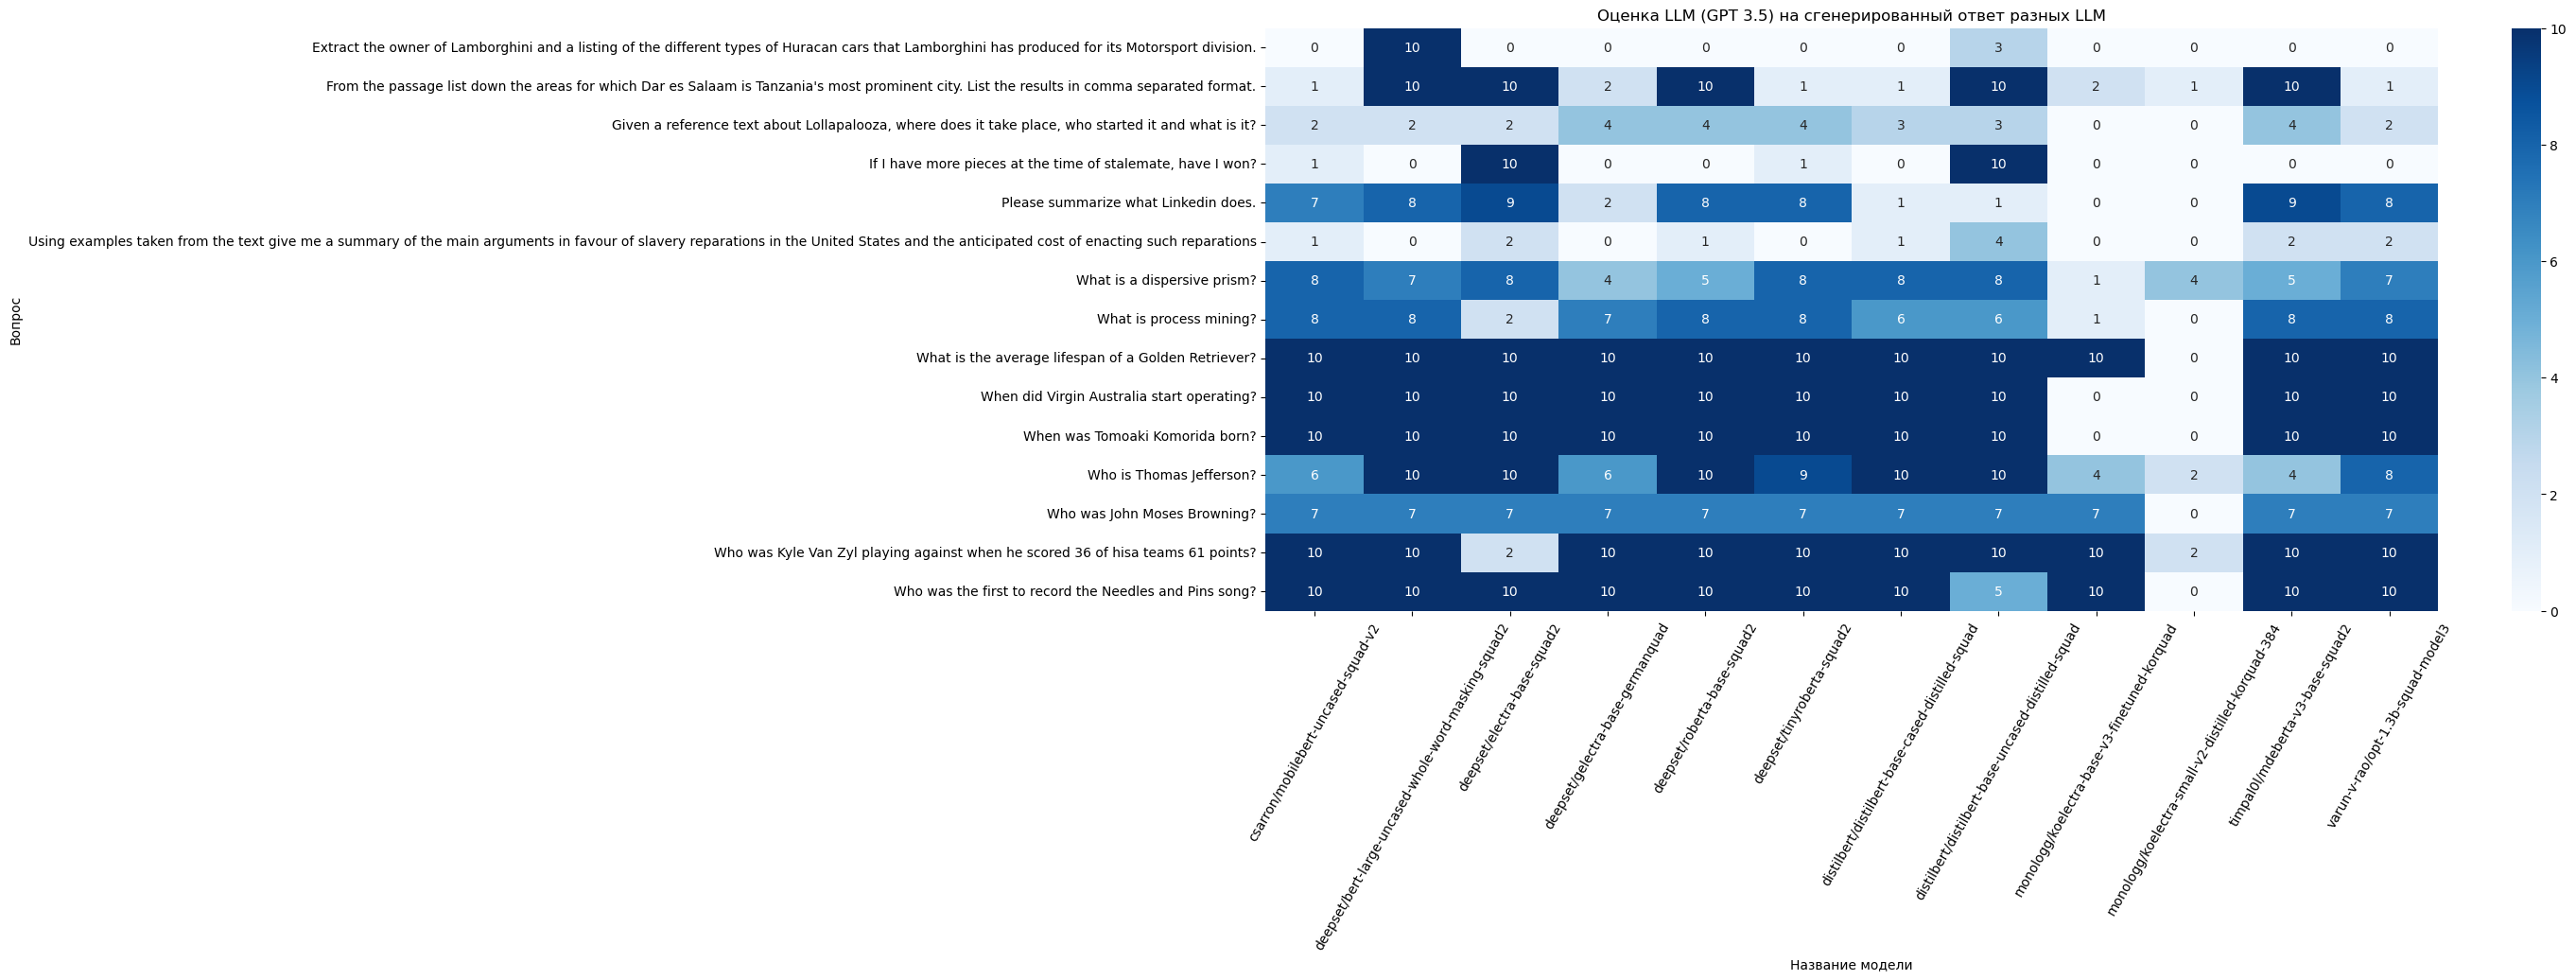

In [3]:
pivot_df = df.pivot(index='question', columns='model_name', values='Score')

plt.figure(figsize=(20, 8))
heatmap = sns.heatmap(pivot_df, annot=True, cmap="Blues")
plt.title("Оценка LLM (GPT 3.5) на сгенерированный ответ разных LLM")
plt.ylabel("Вопрос")
plt.xlabel("Название модели")
plt.xticks(rotation=60)  # Rotate model names for better readability
plt.yticks(rotation=0)

plt.show()

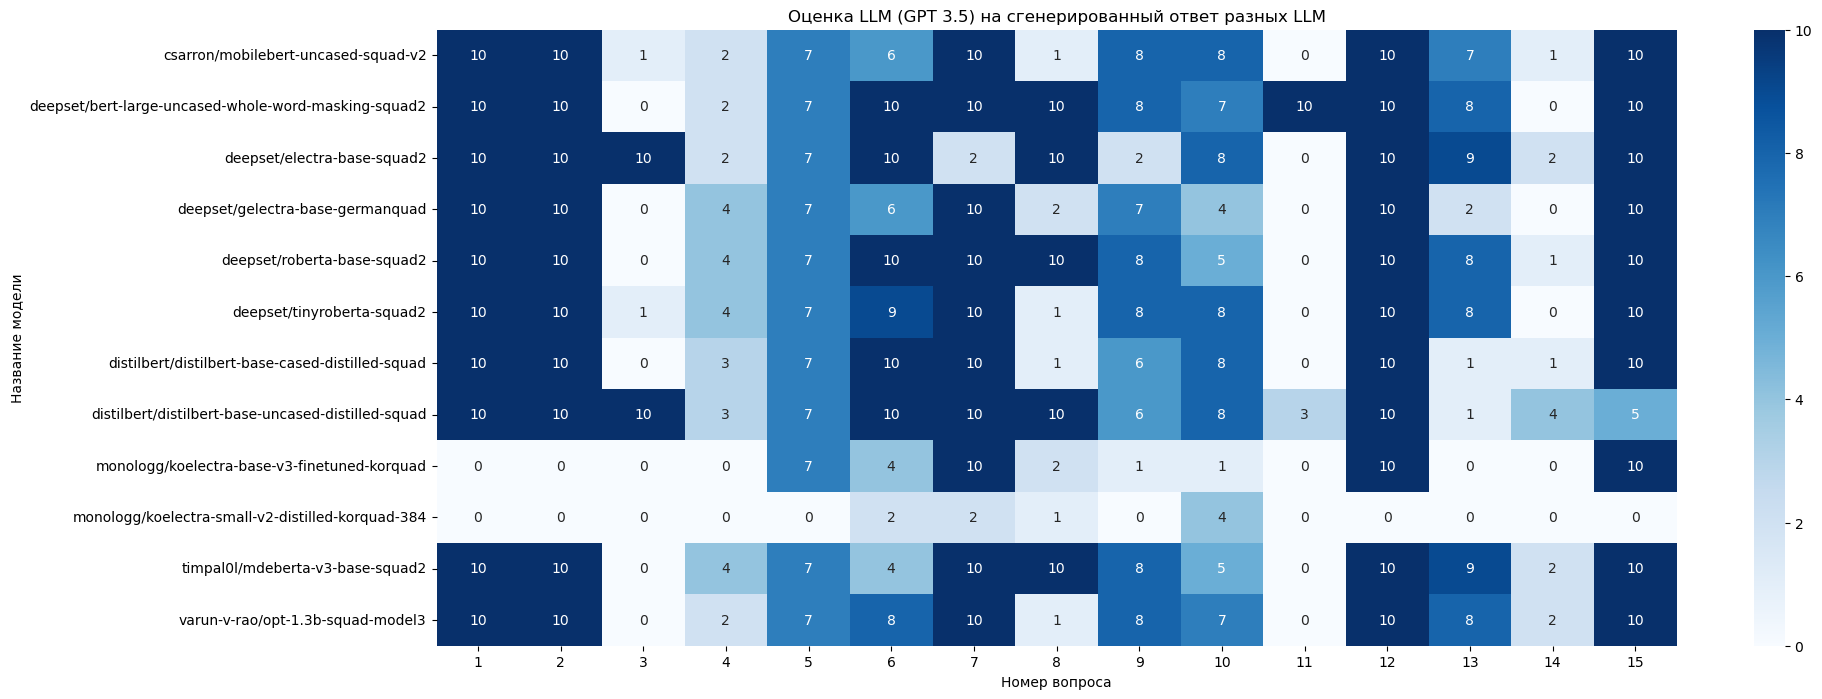

In [4]:
pivot_df = df.pivot(index='model_name', columns='question_num', values='Score')

plt.figure(figsize=(20, 8))
heatmap = sns.heatmap(pivot_df, annot=True, cmap="Blues")
plt.title("Оценка LLM (GPT 3.5) на сгенерированный ответ разных LLM")
plt.ylabel("Название модели")
plt.xlabel("Номер вопроса")
# plt.xticks(rotation=60)  # Rotate model names for better readability
plt.yticks(rotation=0)

plt.show()

### Анализ моделей

In [5]:
model_mean_score = df.groupby('model_name')[
    'Score'].mean().round(2).reset_index()
model_mean_score.sort_values(
    by='Score', ascending=False).reset_index(drop=True)

,model_name,Score
0,deepset/bert-large-uncased-whole-word-masking-...,7.47
1,distilbert/distilbert-base-uncased-distilled-s...,7.13
2,deepset/roberta-base-squad2,6.87
3,deepset/electra-base-squad2,6.80
4,timpal0l/mdeberta-v3-base-squad2,6.60
5,deepset/tinyroberta-squad2,6.40
6,varun-v-rao/opt-1.3b-squad-model3,6.20
7,csarron/mobilebert-uncased-squad-v2,6.07
8,distilbert/distilbert-base-cased-distilled-squad,5.80
9,deepset/gelectra-base-germanquad,5.47


In [8]:
models_df = models_df.merge(model_mean_score, on='model_name')
models_df

,model_name,link,model_size(M),Score
0,monologg/koelectra-small-v2-distilled-korquad-384,https://huggingface.co/monologg/koelectra-smal...,13,0.60
1,distilbert/distilbert-base-cased-distilled-squad,https://huggingface.co/distilbert/distilbert-b...,65,5.80
2,distilbert/distilbert-base-uncased-distilled-s...,https://huggingface.co/distilbert/distilbert-b...,66,7.13
3,deepset/tinyroberta-squad2,https://huggingface.co/deepset/tinyroberta-squad2,81,6.40
4,csarron/mobilebert-uncased-squad-v2,https://huggingface.co/csarron/mobilebert-unca...,104,6.07
5,deepset/gelectra-base-germanquad,https://huggingface.co/deepset/gelectra-base-g...,109,5.47
6,deepset/electra-base-squad2,https://huggingface.co/deepset/electra-base-sq...,109,6.80
7,monologg/koelectra-base-v3-finetuned-korquad,https://huggingface.co/monologg/koelectra-base...,112,3.00
8,deepset/roberta-base-squad2,https://huggingface.co/deepset/roberta-base-sq...,124,6.87
9,timpal0l/mdeberta-v3-base-squad2,https://huggingface.co/timpal0l/mdeberta-v3-ba...,278,6.60


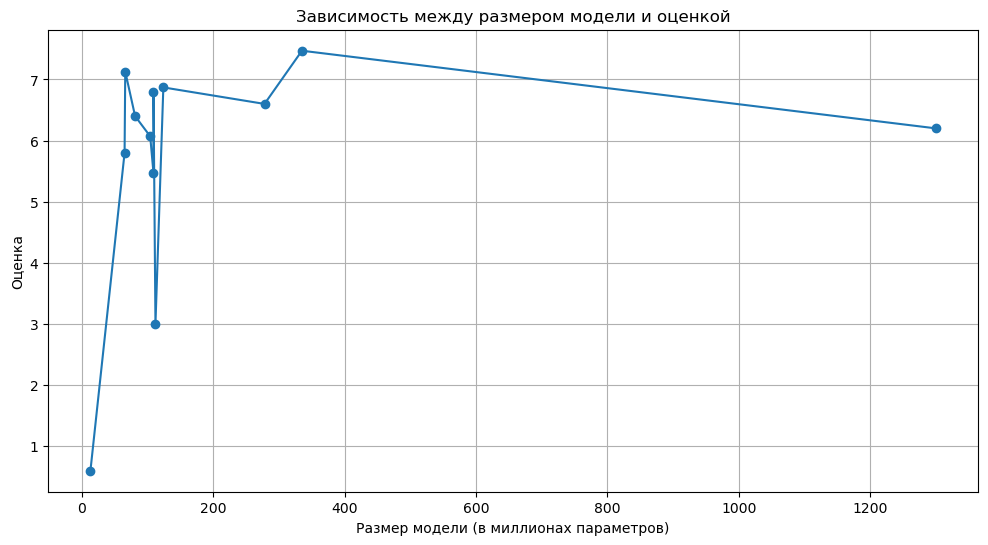

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(models_df['model_size(M)'],
         models_df['Score'], marker='o', linestyle='-')
plt.title('Зависимость между размером модели и оценкой')
plt.xlabel('Размер модели (в миллионах параметров)')
plt.ylabel('Оценка')
plt.grid(True)
plt.show()

In [11]:
import numpy as np

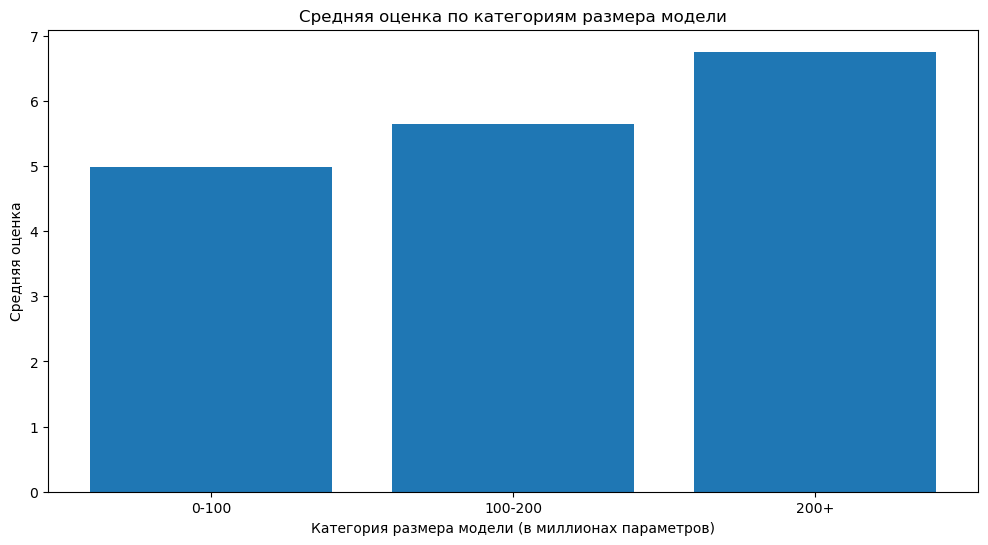

In [12]:
bins = [0, 100, 200, np.inf]
labels = ['0-100', '100-200', '200+']
models_df['model_size_category'] = pd.cut(
    models_df['model_size(M)'], bins=bins, labels=labels, right=False)

mean_scores = models_df.groupby('model_size_category', observed=False)[
    'Score'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(mean_scores['model_size_category'], mean_scores['Score'])
plt.title('Средняя оценка по категориям размера модели')
plt.xlabel('Категория размера модели (в миллионах параметров)')
plt.ylabel('Средняя оценка')
plt.grid(False)
plt.show()

In [13]:
mean_scores

,model_size_category,Score
0,0-100,4.982500
1,100-200,5.642000
2,200+,6.756667


In [14]:
models_df

,model_name,link,model_size(M),Score,model_size_category
0,monologg/koelectra-small-v2-distilled-korquad-384,https://huggingface.co/monologg/koelectra-smal...,13,0.60,0-100
1,distilbert/distilbert-base-cased-distilled-squad,https://huggingface.co/distilbert/distilbert-b...,65,5.80,0-100
2,distilbert/distilbert-base-uncased-distilled-s...,https://huggingface.co/distilbert/distilbert-b...,66,7.13,0-100
3,deepset/tinyroberta-squad2,https://huggingface.co/deepset/tinyroberta-squad2,81,6.40,0-100
4,csarron/mobilebert-uncased-squad-v2,https://huggingface.co/csarron/mobilebert-unca...,104,6.07,100-200
5,deepset/gelectra-base-germanquad,https://huggingface.co/deepset/gelectra-base-g...,109,5.47,100-200
6,deepset/electra-base-squad2,https://huggingface.co/deepset/electra-base-sq...,109,6.80,100-200
7,monologg/koelectra-base-v3-finetuned-korquad,https://huggingface.co/monologg/koelectra-base...,112,3.00,100-200
8,deepset/roberta-base-squad2,https://huggingface.co/deepset/roberta-base-sq...,124,6.87,100-200
9,timpal0l/mdeberta-v3-base-squad2,https://huggingface.co/timpal0l/mdeberta-v3-ba...,278,6.60,200+


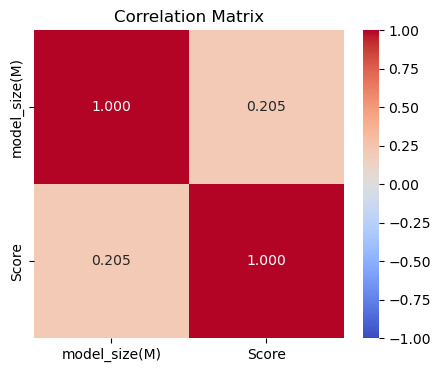

In [15]:
correlation_matrix = models_df[['model_size(M)', 'Score']].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True,
            cmap='coolwarm', fmt=".3f", vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [18]:
questions_scores = df.groupby('question')['Score'].mean().reset_index()
questions_scores = questions_scores.sort_values(
    by='Score', ascending=False).reset_index(drop=True).round(2)
questions_scores

,question,Score
0,What is the average lifespan of a Golden Retri...,9.17
1,Who was the first to record the Needles and Pi...,8.75
2,Who was Kyle Van Zyl playing against when he s...,8.67
3,When did Virgin Australia start operating?,8.33
4,When was Tomoaki Komorida born?,8.33
5,Who is Thomas Jefferson?,7.42
6,Who was John Moses Browning?,6.42
7,What is a dispersive prism?,6.08
8,What is process mining?,5.83
9,Please summarize what Linkedin does.,5.08


In [208]:
# 2 Самых простых вопроса
questions_scores['question'].iloc[:2].values

array(['What is the average lifespan of a Golden Retriever?',
       'Who was the first to record the Needles and Pins song?'],
      dtype=object)

In [209]:
# 2 Самых сложных вопроса
questions_scores['question'].iloc[-2:].values

array(['Extract the owner of Lamborghini and a listing of the different types of Huracan cars that Lamborghini has produced for its Motorsport division.',
       'Using examples taken from the text give me a summary of the main arguments in favour of slavery reparations in the United States and the anticipated cost of enacting such reparations'],
      dtype=object)